<div class="alert alert-success" role="alert", align="center">

# Reactive covering

### M - N

</div>

In [1]:
from matplotlib import pyplot as plt
import cartopy
cartopy.config['data_dir']
import cartopy.crs as ccrs
import cartopy.feature as cf
import math
import random
import json
import time
import numpy as np 
from docplex.mp.model import Model

def showSolution(data, solution, filename):
    
    # print the booking strategy
    print("Bookings:")
    for booking in solution['Bookings']:
        print(booking)

    # show the passes
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    nAOIs = len(AOIs)
    accesses = data['Accesses']
    satPasses = data['Passes']
    nPasses = len(satPasses)
    
    ncols = 3
    nrows = math.ceil(nPasses / ncols)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': proj},figsize=(30,80))
    axs = axs.flatten()

    for i in range(nPasses):
        satPass = satPasses[i]
        ax = axs[i]
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        #plt.gcf().set_size_inches(15, 15)    
        for aoi in  AOIs:
            ax.plot([aoi['lon']], [aoi['lat']], 'kx')
        ax.set_title("Pass #{} [{},{}]".format(i,satPass['startDate'],satPass['endDate']))
    
        booking = None
        for bk in solution['Bookings']:
            if bk['passId'] == i:
                booking = bk            
                break
        
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]            
            ax.plot([aoi['lon']], [aoi['lat']], 'rx')
            # show the reservations
            if (booking != None) and (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                ax.plot([aoi['lon']], [aoi['lat']], 'bo')

    plt.show()
    plt.savefig(filename)
    plt.close()

<div class="alert alert-info" role="alert", align="center">
  
# Etape 1       
## Glouton naïf
### Prise en main
</div>

In [6]:
# import the data

debut = time.time()
dataFile = open('data/data12.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes'];
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']

# a very basic solver

remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    coveredByPass = 0
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                coveredByPass += 1
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    # métrique sur la rentabilité de chaque passe satellite            
    startPass = satPass['start']
    endPass = satPass['end']
    
    passDuration = endPass - startPass
    
    satPassCost = fixedPassCost + passDuration*passCostPerTimeUnit
    
    passEfficiency = coveredByPass/satPassCost
    print(f'Identifiant de la passe: {i}; \t  Rentabilité de la passe: {passEfficiency}')
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break


print(selectedPassIds)
print(len(selectedPassIds))

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()
fin = time.time()
print(f"Temps d'exécution: {fin - debut:.6f}s")

Identifiant de la passe: 58; 	  Rentabilité de la passe: 0.18974358974358974
Identifiant de la passe: 32; 	  Rentabilité de la passe: 0.10526315789473684
Identifiant de la passe: 11; 	  Rentabilité de la passe: 0.02631578947368421
Identifiant de la passe: 20; 	  Rentabilité de la passe: 0.1018957345971564
Identifiant de la passe: 53; 	  Rentabilité de la passe: 0.10112359550561797
Identifiant de la passe: 26; 	  Rentabilité de la passe: 0.023655913978494623
Identifiant de la passe: 42; 	  Rentabilité de la passe: 0.0199501246882793
Identifiant de la passe: 46; 	  Rentabilité de la passe: 0.0045351473922902496
Identifiant de la passe: 62; 	  Rentabilité de la passe: 0.010752688172043012
Identifiant de la passe: 22; 	  Rentabilité de la passe: 0.0058309037900874635
[58, 32, 11, 20, 53, 26, 42, 46, 62, 22]
10
Temps d'exécution: 0.025716s


<div class="alert alert-danger" role="alert", align="center">

## ⚠️ Code long ⚠️

### Le code qui suit effectue 1000 itérations du code précédent, pour moyenner / prendre le minimum du glouton naïf aléatoire.

</div>

In [7]:
nb_tot = []
cost_tot = []
count = 0
while count < 1000:
    dataFile = open('data/data12.json')  
    data = json.load(dataFile)
    accesses = data['Accesses']
    obsRequests = data['ObservationRequests'];
    nObsRequests = len(obsRequests)
    covered = [False for i in range(nObsRequests)]
    nObsRequestsToCover = nObsRequests
    satPasses = data['Passes'];
    nPasses = len(satPasses)
    remainingSatPassesIds = list(range(nPasses))
    random.shuffle(remainingSatPassesIds)
    selectedPassIds = []
    for i in remainingSatPassesIds:
        # try to select the ith path
        satPass = satPasses[i]
        keepPass = False
        coveredByPass = 0
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            for j in range(nObsRequests):
                obsRequest = obsRequests[j]
                if not covered[j] and accessId in obsRequest['accessIds']:
                    coveredByPass += 1
                    covered[j] = True
                    keepPass = True
                    nObsRequestsToCover -= 1

        # métrique sur la rentabilité de chaque passe satellite            
        startPass = satPass['start']
        endPass = satPass['end']

        passDuration = endPass - startPass

        satPassCost = fixedPassCost + passDuration*passCostPerTimeUnit

        passEfficiency = coveredByPass/satPassCost

        if keepPass:
            selectedPassIds.append(i)

        if nObsRequestsToCover == 0:
            break
            
    nbSatPass = len(selectedPassIds)
    passesDuration = 0
    for passId in selectedPassIds: 
        startPass = data['Passes'][passId]['start']
        endPass = data['Passes'][passId]['end']

        passesDuration += endPass - startPass

    cost = fixedPassCost*nbSatPass + passesDuration*passCostPerTimeUnit
    cost_tot.append(cost)
    nb_tot.append(len(selectedPassIds))
    
    count += 1

In [8]:
print(f"Nombre moyen de passes: {np.mean(nb_tot)}")
print(f"Coût moyen: {np.mean(cost_tot)}€")

Nombre moyen de passes: 10.041
Coût moyen: 3626.94€


<div class="alert alert-info" role="alert", align="center">

# Etape 2   
## Glouton guidé
### Amélioration du glouton naïf
</div>

In [10]:
# Définition de la fonction de rendement

def bestPassId(remainingSatPassesIds, covered):
    passesEff = {}
    for i in remainingSatPassesIds:
        satPass = satPasses[i]

        coveredByPass = 0
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            for j in range(nObsRequests):
                obsRequest = obsRequests[j]
                if not covered[j] and accessId in obsRequest['accessIds']:
                    coveredByPass += 1
                
        startPass = satPass['start']
        endPass = satPass['end']

        passDuration = endPass - startPass
        satPassCost = fixedPassCost + passDuration*passCostPerTimeUnit
        passEfficiency = coveredByPass/satPassCost

        passesEff[i] = passEfficiency
        
        
    return max(passesEff, key=passesEff.get)

In [11]:
debut = time.time()
# import the data
reactivity = 12
dataFile = open(f'data/data{reactivity}.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes'];
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']


remainingSatPassesIds = list(range(nPasses))
selectedPassIds = []
passesEff = {}
for k in remainingSatPassesIds:
    # try to select the ith path
    i = bestPassId(remainingSatPassesIds, covered)
    remainingSatPassesIds.remove(i)
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1

                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break


print(selectedPassIds)
print(len(selectedPassIds))


nbSatPass = len(selectedPassIds)

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open(f"solution_glouton_{reactivity}.json", "w")
jsonFile.write(jsonString)
jsonFile.close()


fin = time.time()
print(f"Elapsed time: {fin - debut:.6f}s")

nbCovered = 0
for i in covered:
    nbCovered += i
    
print(f"Percentage of satified requests: {((nbCovered/nObsRequests*100)):.2f} %")


passesDuration = 0
for passId in selectedPassIds: 
    startPass = data['Passes'][passId]['start']
    endPass = data['Passes'][passId]['end']
    
    passesDuration += endPass - startPass
    
cost = fixedPassCost*nbSatPass + passesDuration*passCostPerTimeUnit
print(f"Total cost: {int(cost)} €")


[18, 30, 23, 62, 58, 15]
6
Elapsed time: 0.354286s
Percentage of satified requests: 100.00 %
Total cost: 2122 €


<div class="alert alert-warning" role="alert", align="center">

# MILP avec sélection de passages complets

### Comparaison avec le glouton guidé
    
</div>

In [12]:
debut = time.time()

dataFile = open('data/data4.json')  
data = json.load(dataFile)
accesses = data['Accesses']
nbAccesses = len(accesses)
obsRequests = data['ObservationRequests']
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes']
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']

# Satisfaction score
satisfaction_score = 0.98

# Création du modèle
model = Model(name='Projet')

# Variables
p = model.binary_var_list(nPasses, name='p')
r = model.binary_var_list(nObsRequests, name='r')
a = model.binary_var_list(nbAccesses, name='a')

# Objectif
model.minimize(model.sum(p[i]*(fixedPassCost + (satPasses[i]['end'] - satPasses[i]['start'])*passCostPerTimeUnit) for i in range(nPasses)))

# Contraintes
for i in range(nPasses):
    for k in satPasses[i]['accessIds']:
        model.add_constraint(p[i] >= a[k])
        
for j in range(nObsRequests):
    model.add_constraint(model.sum(a[k] for k in obsRequests[j]['accessIds']) >= 1 - nbAccesses*(1- r[j]))

model.add_constraint(model.sum(r[j] for j in range(nObsRequests))/nObsRequests >= satisfaction_score)

model.print_information()

solution = model.solve(log_output=True)
nbSelectedPasses = sum(solution[p[i]] for i in range(nPasses))
selectedPasses = [i for i in range(nPasses) if solution[p[i]]==1]
cost = solution.get_objective_value()
gap_to_best_bound = model.solve_details.mip_relative_gap

fin = time.time()
print("\n***********************")
print(f"Elapsed time: {fin - debut:.6f}s")
print(f"Minimum satifaction rate: {satisfaction_score*100:.2f}%")
print(f"Number of selected passes: {int(nbSelectedPasses)}")
print(f"Selected passes: {selectedPasses}")
print(f"Total cost: {int(round(cost, 0))}€")
print(f"Best bound: {int(round(model.solve_details.best_bound, 0))}€")
print(f"Gap to best bound: {gap_to_best_bound*100:.2f}%")

Model: Projet
 - number of variables: 5890
   - binary=5890, integer=0, continuous=0
 - number of constraints: 5822
   - linear=5822
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 3 times.
MIP Presolve eliminated 16 rows and 17 columns.
MIP Presolve modified 4468 coefficients.
Aggregator did 3599 substitutions.
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (23.46 ticks)
Found incumbent of value 18191.000000 after 0.03 sec. (26.66 ticks)
Probing time = 0.00 sec. (0.40 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. 

<div class="alert alert-danger" role="alert", align="center">

## ⚠️ Code long ⚠️

### Le code qui suit effectue 19 résolutions du problème ci-dessus pour différents taux de satisfaction. Pour ensuite tracer le coût en fonction du taux de satisfaction.

</div>

In [8]:
dataFile = open('data/data4.json')  
data = json.load(dataFile)
accesses = data['Accesses']
nbAccesses = len(accesses)
obsRequests = data['ObservationRequests']
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes']
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']

res = []
# Satisfaction score
for satisfaction_score in np.arange(0.05, 1, 0.05):

    # Création du modèle
    model = Model(name='Projet')

    # Variables
    p = model.binary_var_list(nPasses, name='p')
    r = model.binary_var_list(nObsRequests, name='r')
    a = model.binary_var_list(nbAccesses, name='a')

    # Objectif
    model.minimize(model.sum(p[i]*(fixedPassCost + (satPasses[i]['end'] - satPasses[i]['start'])*passCostPerTimeUnit) for i in range(nPasses)))

    # Contraintes
    for i in range(nPasses):
        for k in satPasses[i]['accessIds']:
            model.add_constraint(p[i] >= a[k])

    for j in range(nObsRequests):
        model.add_constraint(model.sum(a[k] for k in obsRequests[j]['accessIds']) >= 1 - nbAccesses*(1- r[j]))

    model.add_constraint(model.sum(r[j] for j in range(nObsRequests))/nObsRequests >= satisfaction_score)

    model.print_information()

    solution = model.solve(log_output=True)
    nbSelectedPasses = sum(solution[p[i]] for i in range(nPasses))
    selectedPasses = [i for i in range(nPasses) if solution[p[i]]==1]
    cost = solution.get_objective_value()
    gap_to_best_bound = model.solve_details.mip_relative_gap

    res.append([satisfaction_score, nbSelectedPasses, cost, model.solve_details.best_bound, fin - debut])

Model: Projet
 - number of variables: 5890
   - binary=5890, integer=0, continuous=0
 - number of constraints: 5822
   - linear=5822
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 3 times.
MIP Presolve eliminated 16 rows and 17 columns.
MIP Presolve modified 4468 coefficients.
Aggregator did 3599 substitutions.
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (23.46 ticks)
Found incumbent of value 18191.000000 after 0.02 sec. (26.77 ticks)
Probing time = 0.00 sec. (0.40 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. 

Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (17.92 ticks)
Probing time = 0.00 sec. (0.40 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.05 sec. (82.85 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        18191.0000        0.0000           100.00%
*     0+    0                         5486.0000        0.0000           100.00%
*     0+    0                         5062.0000        0.0000           100.00%
*     0+    0                         4708.0000        0.0000           100.00%
*     0+    0                         4365.0000        0.0000           100.00%
      0     0      378.6486   555     4365.0000      378.6486     2211   91.33%
*     0+    0                        

Aggregator did 3599 substitutions.
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (23.46 ticks)
Found incumbent of value 18191.000000 after 0.02 sec. (26.81 ticks)
Probing time = 0.00 sec. (0.40 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (17.92 ticks)
Probing time = 0.00 sec. (0.40 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.07 sec. (150.28 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        18191.0000        0.0000           100.00%
*     0+    0  

                          ------------
Total (root+branch&cut) =    0.38 sec. (736.80 ticks)
Model: Projet
 - number of variables: 5890
   - binary=5890, integer=0, continuous=0
 - number of constraints: 5822
   - linear=5822
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 3 times.
MIP Presolve eliminated 16 rows and 17 columns.
MIP Presolve modified 4468 coefficients.
Aggregator did 3599 substitutions.
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (23.46 ticks)
Found incumbent of value 18191.000000 after 0.02 sec. (26.66 ticks)
Probing time = 0.00 sec. (0.40 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Re

Aggregator did 3599 substitutions.
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (23.46 ticks)
Found incumbent of value 18191.000000 after 0.03 sec. (26.69 ticks)
Probing time = 0.00 sec. (0.40 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2207 rows, 2274 columns, and 18486 nonzeros.
Reduced MIP has 2274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (17.92 ticks)
Probing time = 0.00 sec. (0.40 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.10 sec. (236.62 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        18191.0000        0.0000           100.00%
*     0+    0  

   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        18191.0000        0.0000           100.00%
*     0+    0                         7220.0000        0.0000           100.00%
*     0+    0                         6830.0000        0.0000           100.00%
*     0+    0                         6727.0000        0.0000           100.00%
*     0+    0                         6495.0000        0.0000           100.00%
*     0+    0                         6429.0000        0.0000           100.00%
*     0+    0                         5945.0000        0.0000           100.00%
*     0+    0                         5578.0000        0.0000           100.00%
*     0+    0                         5154.0000        0.0000           100.00%
*     0+    0                         4921.0000        0.0000           100.00%
      0     0     1581.9695   918     4921.0000     1581.9695       18   67.85%
*     0+    0                         29

*     0+    0                         8132.0000        0.0000           100.00%
*     0+    0                         7966.0000        0.0000           100.00%
*     0+    0                         7611.0000        0.0000           100.00%
*     0+    0                         7498.0000        0.0000           100.00%
*     0+    0                         7389.0000        0.0000           100.00%
*     0+    0                         7096.0000        0.0000           100.00%
*     0+    0                         6694.0000        0.0000           100.00%
*     0+    0                         6547.0000        0.0000           100.00%
*     0+    0                         6325.0000        0.0000           100.00%
      0     0     1990.6752   645     6325.0000     1990.6752       21   68.53%
*     0+    0                         4011.0000     1990.6752            50.37%
*     0+    0                         2884.0000     1990.6752            30.98%
      0     0     1994.8609   709     28

Presolve time = 0.01 sec. (17.92 ticks)
Probing time = 0.00 sec. (0.40 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.08 sec. (156.30 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        18191.0000        0.0000           100.00%
*     0+    0                         8487.0000        0.0000           100.00%
*     0+    0                         8229.0000        0.0000           100.00%
*     0+    0                         8063.0000        0.0000           100.00%
*     0+    0                         7816.0000        0.0000           100.00%
*     0+    0                         7720.0000        0.0000           100.00%
*     0+    0                         7584.0000        0.0000           100.00%
*     0+    0            

Zero-half cuts applied:  81
Lift and project cuts applied:  8
Gomory fractional cuts applied:  1

Root node processing (before b&c):
  Real time             =    1.15 sec. (1366.06 ticks)
Parallel b&c, 20 threads:
  Real time             =    0.53 sec. (563.81 ticks)
  Sync time (average)   =    0.26 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    1.67 sec. (1929.87 ticks)


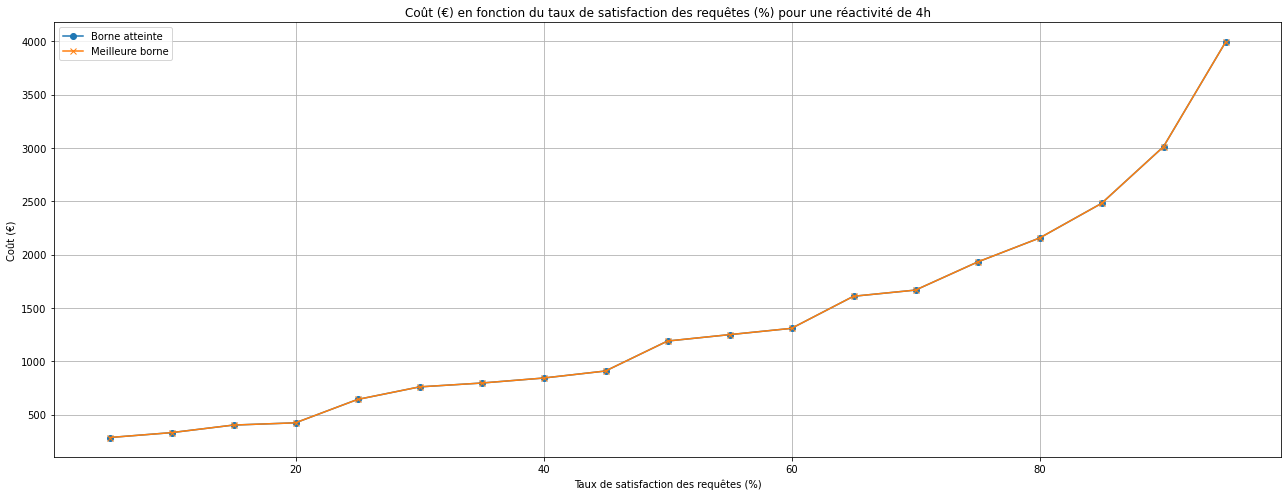

In [9]:
# Affichage des résultats de la cellule précédente
x_values = [point[0]*100 for point in res]
y_values = [point[2] for point in res]
z_values = [point[3] for point in res]

plt.figure(figsize=(22,8))
plt.plot(x_values, y_values, marker='o', label='Borne atteinte')
plt.plot(x_values, z_values, marker='x', label='Meilleure borne')

plt.title('Coût (€) en fonction du taux de satisfaction des requêtes (%) pour une réactivité de 4h')
plt.xlabel('Taux de satisfaction des requêtes (%)')
plt.ylabel('Coût (€)')
plt.legend()
plt.grid()
plt.show()


<div class="alert alert-success" role="alert", align="center">


# Etape 3
## MILP avec sélection de passages partiels

### Optimisation du coût par réduction du temps de réservations
    
</div>

In [13]:
debut = time.time()

dataFile = open('data/data12.json')  
data = json.load(dataFile)
accesses = data['Accesses']
nbAccesses = len(accesses)
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes'];
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']

# Satisfaction score
satisfaction_score = 1

# Création du modèle
model = Model(name='Projet')

# Limite de temps fixée à 20s!
model.set_time_limit(20)

# Variables
p = model.binary_var_list(nPasses, name='p')
r = model.binary_var_list(nObsRequests, name='r')
a = model.binary_var_list(nbAccesses, name='a')
s = model.integer_var_list(nPasses, lb=0, name='s')
e = model.integer_var_list(nPasses, lb=0, name='e')

# Objectif
model.minimize(model.sum(p[i]*(fixedPassCost) + (e[i] - s[i])*passCostPerTimeUnit for i in range(nPasses)))

# Contraintes
for i in range(nPasses):
    # Initialisation de s
    model.add_constraint(s[i] >= satPasses[i]['start'])
    # Initialisation de e
    model.add_constraint(e[i] <= satPasses[i]['end'])
    # La fin de la réservation est après le début de la réservation
    model.add_constraint(e[i] >= s[i])
    # Le temps de réservation est majoré par la durée de la passe
    model.add_constraint(p[i]*(satPasses[i]['end'] - satPasses[i]['start']) >= e[i] - s[i])
    # La durée de réservation est d'au moins 30s
    model.add_constraint(e[i] +  s[i] >= 30)
    
    
    for k in satPasses[i]['accessIds']:
        M1 = satPasses[i]['end'] + 30 - accesses[k]['end']
        M2 = 2*( 30 + accesses[k]['start'] )
        # Si un accès de la passe i est sélectionné, alors la passe i est sélectionnée
        model.add_constraint(p[i] >= a[k])
        model.add_constraint(s[i] + 30 - accesses[k]['end'] <= M1*(1 - a[k]))
        model.add_constraint(accesses[k]['start'] + 30 - e[i] <= M2*(1 - a[k]))
        
for j in range(nObsRequests):
    model.add_constraint(model.sum(a[k] for k in obsRequests[j]['accessIds']) >= 1 - nbAccesses*(1- r[j]))

model.add_constraint(model.sum(r[j] for j in range(nObsRequests))/nObsRequests >= satisfaction_score)


model.print_information()

solution = model.solve(log_output=True)
nbSelectedPasses = sum(solution[p[i]] for i in range(nPasses))
selectedPasses = [i  for i in range(nPasses) if solution[p[i]]==1]
cost = solution.get_objective_value()
gap_to_best_bound = model.solve_details.mip_relative_gap

fin = time.time()
print("\n***********************")
print(f"Elapsed time: {fin - debut:.6f}s")
print(f"Minimum satifaction rate: {satisfaction_score*100:.2f}%")
print(f"Minimum satifaction rate: {satisfaction_score*100:.2f}%")
print(f"Number of selected passes: {int(nbSelectedPasses)}")
print(f"Selected passes: {selectedPasses}")
print(f"Total cost: {int(round(cost, 0))}€")
print(f"Best bound: {int(round(model.solve_details.best_bound, 0))}€")
print(f"Gap to best bound: {gap_to_best_bound*100:.2f}%")

Model: Projet
 - number of variables: 4003
   - binary=3865, integer=138, continuous=0
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 1 time.
MIP Presolve eliminated 207 rows and 225 columns.
MIP Presolve modified 7592 coefficients.
Reduced MIP has 11077 rows, 3778 columns, and 25344 nonzeros.
Reduced MIP has 3640 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (21.01 ticks)
Found incumbent of value 11139.000000 after 0.02 sec. (25.03 ticks)
Probing time = 0.01 sec. (5.68 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11077 rows, 3778 columns, and 25344 nonzeros.
Reduced MIP has 3640 binaries, 1

<div class="alert alert-danger" role="alert", align="center">

## ⚠️ Code long ⚠️

### Le code qui suit effectue 19 résolutions du problème ci-dessus pour différents taux de satisfaction. Pour ensuite tracer le coût en fonction du taux de satisfaction.

</div>

In [18]:
dataFile = open('data/data4.json')  
data = json.load(dataFile)
accesses = data['Accesses']
nbAccesses = len(accesses)
obsRequests = data['ObservationRequests']
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes']
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']

res = []
# Satisfaction score
for satisfaction_score in np.arange(0.05, 1, 0.05):

    # Création du modèle
    model = Model(name='Projet')

    # Limite de temps fixée à 20s!
    model.set_time_limit(20)

    # Variables
    p = model.binary_var_list(nPasses, name='p')
    r = model.binary_var_list(nObsRequests, name='r')
    a = model.binary_var_list(nbAccesses, name='a')
    s = model.integer_var_list(nPasses, lb=0, name='s')
    e = model.integer_var_list(nPasses, lb=0, name='e')

    # Objectif
    model.minimize(model.sum(p[i]*(fixedPassCost) + (e[i] - s[i])*passCostPerTimeUnit for i in range(nPasses)))

    # Contraintes
    for i in range(nPasses):
        # Initialisation de s
        model.add_constraint(s[i] >= satPasses[i]['start'])
        # Initialisation de e
        model.add_constraint(e[i] <= satPasses[i]['end'])
        # La fin de la réservation est après le début de la réservation
        model.add_constraint(e[i] >= s[i])
        # Le temps de réservation est majoré par la durée de la passe
        model.add_constraint(p[i]*(satPasses[i]['end'] - satPasses[i]['start']) >= e[i] - s[i])
        # La durée de réservation est d'au moins 30s
        model.add_constraint(e[i] +  s[i] >= 30)


        for k in satPasses[i]['accessIds']:
            M1 = satPasses[i]['end'] + 30 - accesses[k]['end']
            M2 = 2*( 30 + accesses[k]['start'] )
            # Si un accès de la passe i est sélectionné, alors la passe i est sélectionnée
            model.add_constraint(p[i] >= a[k])
            model.add_constraint(s[i] + 30 - accesses[k]['end'] <= M1*(1 - a[k]))
            model.add_constraint(accesses[k]['start'] + 30 - e[i] <= M2*(1 - a[k]))

    for j in range(nObsRequests):
        model.add_constraint(model.sum(a[k] for k in obsRequests[j]['accessIds']) >= 1 - nbAccesses*(1- r[j]))

    model.add_constraint(model.sum(r[j] for j in range(nObsRequests))/nObsRequests >= satisfaction_score)


    model.print_information()

    solution = model.solve(log_output=True)
    nbSelectedPasses = sum(solution[p[i]] for i in range(nPasses))
    selectedPasses = [i  for i in range(nPasses) if solution[p[i]]==1]
    cost = solution.get_objective_value()
    gap_to_best_bound = model.solve_details.mip_relative_gap

    res.append([satisfaction_score, nbSelectedPasses, cost, model.solve_details.best_bound, fin - debut])

Model: Projet
 - number of variables: 10753
   - binary=10615, integer=138, continuous=0
 - number of constraints: 18034
   - linear=18034
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 2 times.
MIP Presolve eliminated 314 rows and 108 columns.
MIP Presolve modified 20876 coefficients.
Aggregator did 445 substitutions.
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (55.27 ticks)
Found incumbent of value 19614.000000 after 0.05 sec. (65.67 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17275 rows, 10200 columns, and 60829 n

    230   106      238.0000   231      264.0000      120.0000    73103   54.55%
*   415+  126                          262.0000      120.0000            54.20%
    480   231      260.4963  1491      262.0000      120.0000   101055   54.20%
    495    47      154.4680  2494      262.0000      120.0000    42463   54.20%

Implied bound cuts applied:  127
Gomory fractional cuts applied:  1

Root node processing (before b&c):
  Real time             =    6.52 sec. (10230.09 ticks)
Parallel b&c, 20 threads:
  Real time             =   13.52 sec. (9025.10 ticks)
  Sync time (average)   =    4.67 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   20.04 sec. (19255.18 ticks)
Model: Projet
 - number of variables: 10753
   - binary=10615, integer=138, continuous=0
 - number of constraints: 18034
   - linear=18034
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifie

Presolve time = 0.04 sec. (75.19 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.87 sec. (1245.07 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        19614.0000   -14341.0000           173.12%
*     0+    0                        15985.0000   -14341.0000           189.72%
*     0+    0                        15511.0000   -14341.0000           192.46%
*     0+    0                        11933.0000   -14341.0000           220.18%
      0     0      175.3012  2098    11933.0000      175.3012       41   98.53%
*     0+    0                        11770.0000      175.3012            98.51%
*     0+    0                        11697.0000      175.3012            98.

   1708   890      688.0000  1112      695.0000      258.1051    76647   62.86%
Elapsed time = 16.40 sec. (17411.41 ticks, tree = 5.84 MB, solutions = 9)
   2990  1642      680.0000   967      695.0000      258.1051   114253   62.86%
*  3043+ 1431                          678.0000      258.1051            61.93%
   3043  1473      628.0000   835      678.0000      258.1051   106034   61.93%

Implied bound cuts applied:  123
Zero-half cuts applied:  513
Lift and project cuts applied:  1
Gomory fractional cuts applied:  2

Root node processing (before b&c):
  Real time             =    7.49 sec. (14112.79 ticks)
Parallel b&c, 20 threads:
  Real time             =   12.55 sec. (5912.11 ticks)
  Sync time (average)   =    4.30 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   20.03 sec. (20024.90 ticks)
Model: Projet
 - number of variables: 10753
   - binary=10615, integer=138, continuous=0
 - number of constraints: 18034
   - li

*     0+    0                        11990.0000   -14341.0000           219.61%
*     0+    0                        11929.0000   -14341.0000           220.22%
*     0+    0                        11877.0000   -14341.0000           220.75%
*     0+    0                        11825.0000   -14341.0000           221.28%
*     0+    0                        11779.0000   -14341.0000           221.75%
*     0+    0                        11740.0000   -14341.0000           222.16%
*     0+    0                        11702.0000   -14341.0000           222.55%
*     0+    0                        11687.0000   -14341.0000           222.71%
      0     0      338.9546  4201    11687.0000      338.9546       67   97.10%
*     0+    0                        11549.0000      338.9546            97.07%
*     0+    0                        11548.0000      338.9546            97.06%
      0     0      344.0984  4577    11548.0000      Cuts: 22      144   97.02%
      0     0      348.6695  5367    115

      0     0      457.3805  5701     1346.0000     Cuts: 250     2219   66.02%
      0     0      457.5380  5494     1346.0000      Cuts: 48     2319   66.01%
      0     0      457.6355  5092     1346.0000      Cuts: 74     2369   66.00%
      0     0      457.7435  5078     1346.0000     Cuts: 150     2424   65.99%
      0     0      457.8127  5081     1346.0000      Cuts: 88     2475   65.99%
      0     0      457.8642  5568     1346.0000      Cuts: 20     2518   65.98%
      0     2      457.8642  5568     1346.0000      459.4364     2518   65.87%
Elapsed time = 19.40 sec. (36262.88 ticks, tree = 0.02 MB, solutions = 12)
      1     3      493.0584  5261     1346.0000      459.4364     3237   65.87%
*     2+    1                         1344.0000      459.4364            65.82%
      2     3      458.5722  5633     1344.0000      459.4364     2761   65.82%

Implied bound cuts applied:  112
Zero-half cuts applied:  225
Gomory fractional cuts applied:  3

Root node processing (befo

*     0+    0                        11990.0000   -14341.0000           219.61%
*     0+    0                        11929.0000   -14341.0000           220.22%
*     0+    0                        11877.0000   -14341.0000           220.75%
*     0+    0                        11825.0000   -14341.0000           221.28%
*     0+    0                        11779.0000   -14341.0000           221.75%
*     0+    0                        11740.0000   -14341.0000           222.16%
*     0+    0                        11702.0000   -14341.0000           222.55%
*     0+    0                        11687.0000   -14341.0000           222.71%
      0     0      547.7159  3981    11687.0000      547.7159       48   95.31%
*     0+    0                        11599.0000      547.7159            95.28%
      0     0      554.2443  5879    11599.0000      Cuts: 60      254   95.22%
      0     0      560.2208  5602    11599.0000     Cuts: 350      428   95.17%
      0     0      567.4929  5478    115

CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 2 times.
MIP Presolve eliminated 314 rows and 108 columns.
MIP Presolve modified 20876 coefficients.
Aggregator did 445 substitutions.
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (55.27 ticks)
Found incumbent of value 19614.000000 after 0.05 sec. (65.38 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (75.19 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, 

      0     0      925.0489  5874    11146.0000     Cuts: 470     2893   91.70%
      0     0      925.3997  5770    11146.0000     Cuts: 354     2976   91.70%
*     0+    0                         6005.0000      925.3997            84.59%
      0     0      925.7042  5889     6005.0000     Cuts: 183     3082   84.58%
*     0+    0                         5961.0000      925.7042            84.47%
      0     0  -1.00000e+75     0     5961.0000      925.7042     3082   84.47%
*     0+    0                         3939.0000      925.7042            76.50%
      0     0      926.0559  5945     3939.0000     Cuts: 269     3218   76.49%
      0     0      926.3094  5886     3939.0000      Cuts: 67     3320   76.48%
      0     0      926.4452  5900     3939.0000     Cuts: 150     3408   76.48%
      0     0      926.5498  5891     3939.0000      Cuts: 54     3467   76.48%
Advanced basis not built.

Implied bound cuts applied:  144
Zero-half cuts applied:  213
Gomory fractional cuts applied:

*     0+    0                        11702.0000   -14341.0000           222.55%
*     0+    0                        11687.0000   -14341.0000           222.71%
      0     0     1065.7698  4318    11687.0000     1065.7698       43   90.88%
*     0+    0                        11554.0000     1065.7698            90.78%
      0     0     1081.1830  4339    11554.0000      Cuts: 56      245   90.64%
      0     0     1096.7958  4285    11554.0000     Cuts: 149      426   90.51%
*     0+    0                        11247.0000     1096.7958            90.25%
      0     0     1117.3575  4047    11247.0000     Cuts: 186      669   90.07%
*     0+    0                        11174.0000     1117.3575            90.00%
      0     0  -1.00000e+75     0    11174.0000     1117.3575      669   90.00%
      0     0     1135.8394  3857    11174.0000     Cuts: 104      931   89.83%
      0     0     1152.1348  4236    11174.0000      Cuts: 40     1131   89.69%
      0     0     1170.1205  4205    111

*     0+    0                        10433.0000     1421.4310            86.38%
*     0+    0                        10431.0000     1421.4310            86.37%
      0     0     1421.6378  4737    10431.0000     Cuts: 121     4979   86.37%
*     0+    0                        10205.0000     1421.6378            86.07%
      0     0  -1.00000e+75     0    10205.0000     1421.6378     4979   86.07%
      0     0     1427.2847  4737    10205.0000     Cuts: 167     5286   85.99%
      0     0     1429.9986  4820    10205.0000     Cuts: 428     5679   85.99%
      0     0     1430.6320  4832    10205.0000     Cuts: 327     5889   85.98%
      0     0     1431.3076  4831    10205.0000      Cuts: 61     6007   85.97%
      0     0     1431.7268  4788    10205.0000      Cuts: 50     6119   85.97%
      0     0     1431.8950  4790    10205.0000      Cuts: 90     6189   85.97%
Advanced basis not built.

Implied bound cuts applied:  104
Zero-half cuts applied:  324
Gomory fractional cuts applied:

CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 2 times.
MIP Presolve eliminated 314 rows and 108 columns.
MIP Presolve modified 20876 coefficients.
Aggregator did 445 substitutions.
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (55.27 ticks)
Found incumbent of value 19614.000000 after 0.05 sec. (65.72 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (75.19 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, 

CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 2 times.
MIP Presolve eliminated 314 rows and 108 columns.
MIP Presolve modified 20876 coefficients.
Aggregator did 445 substitutions.
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (55.27 ticks)
Found incumbent of value 19917.000000 after 0.06 sec. (65.67 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17275 rows, 10200 columns, and 60829 nonzeros.
Reduced MIP has 10062 binaries, 138 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (75.19 ticks)
Probing time = 0.03 sec. (8.23 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution ti

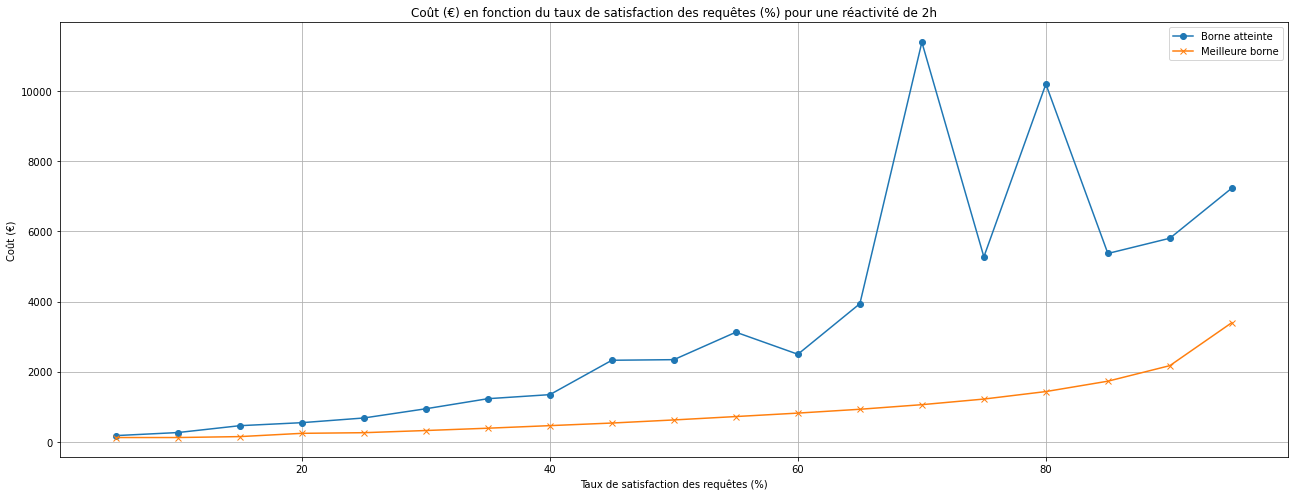

In [19]:
# Affichage des résultats de la cellule précédente
x_values = [point[0]*100 for point in res]
y_values = [point[2] for point in res]
z_values = [point[3] for point in res]

plt.figure(figsize=(22,8))
plt.plot(x_values, y_values, marker='o', label='Borne atteinte')
plt.plot(x_values, z_values, marker='x', label='Meilleure borne')

plt.title('Coût (€) en fonction du taux de satisfaction des requêtes (%) pour une réactivité de 4h')
plt.xlabel('Taux de satisfaction des requêtes (%)')
plt.ylabel('Coût (€)')
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-info" role="alert", align="center">


# Etape 4   
## MILP avec sélection de passages partiels et multi-objectifs

### Permet de prévilégier le taux de satisfaction aux coûts ou l'inverse
    
</div>

In [7]:
debut = time.time()

dataFile = open('data/data12.json')  
data = json.load(dataFile)
accesses = data['Accesses']
nbAccesses = len(accesses)
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes'];
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']
alpha = 0.98

satisfaction_score = 0.8

# Création du modèle
model = Model(name='Projet')
model.set_time_limit(20)

# Variables
p = model.binary_var_list(nPasses, name='p')
r = model.binary_var_list(nObsRequests, name='r')
a = model.binary_var_list(nbAccesses, name='a')
s = model.continuous_var_list(nPasses, lb=0, name='s')
e = model.continuous_var_list(nPasses, lb=0, name='e')

# Objectif
C1max = fixedPassCost*nPasses + sum(pa['end'] - pa['start'] for pa in satPasses)*passCostPerTimeUnit

model.minimize(alpha*(model.sum(p[i]*fixedPassCost + (e[i] - s[i])*passCostPerTimeUnit for i in range(nPasses))
                      /C1max)
               - (1 - alpha)*model.sum(r[j]/nObsRequests for j in range(nObsRequests)))
               

# Contraintes
for i in range(nPasses):
    # Initialisation de s
    model.add_constraint(s[i] >= satPasses[i]['start'])
    # Initialisation de e
    model.add_constraint(e[i] <= satPasses[i]['end'])
    # La fin de la réservation est après le début de la réservation
    model.add_constraint(e[i] >= s[i])
    # Le temps de réservation est majoré par la durée de la passe
    model.add_constraint(p[i]*(satPasses[i]['end'] - satPasses[i]['start']) >= e[i] - s[i])
    # La durée de réservation est d'au moins 30s
    model.add_constraint(e[i] +  s[i] >= 30)
    
    
    for k in satPasses[i]['accessIds']:
        M1 = satPasses[i]['end'] + 30 - accesses[k]['end']
        M2 = 2*( 30 + accesses[k]['start'] )
        # Si un accès de la passe i est sélectionné, alors la passe i est sélectionnée
        model.add_constraint(p[i] >= a[k])
        model.add_constraint(s[i] + 30 - accesses[k]['end'] <= M1*(1 - a[k]))
        model.add_constraint(accesses[k]['start'] + 30 - e[i] <= M2*(1 - a[k]))
    
        
for j in range(nObsRequests):
    model.add_constraint(model.sum(a[k] for k in obsRequests[j]['accessIds']) >= 1 - nbAccesses*(1- r[j]))

model.add_constraint(model.sum(r[j] for j in range(nObsRequests))/nObsRequests >= satisfaction_score)
    
model.print_information()

solution = model.solve(log_output=True)
nbSelectedPasses = sum(solution[p[i]] for i in range(nPasses))
satisfiedRequestsRate = sum(solution[r[j]] for j in range(nObsRequests))/nObsRequests
selectedPasses = [i  for i in range(nPasses) if solution[p[i]]==1]
obj_value = solution.get_objective_value()
cost = (C1max/alpha)*(obj_value + (1-alpha)*satisfiedRequestsRate)
best_bound = (C1max/alpha)*(model.solve_details.best_bound + (1-alpha)*satisfiedRequestsRate)
gap_to_best_bound = best_bound/cost
fin = time.time()

print("\n***********************")
print(f"Elapsed time: {fin - debut:.6f}s")
print(f"Minimum satifaction rate: {satisfaction_score*100:.2f}%")
print(f"Percentage of satified requests: {satisfiedRequestsRate*100:.2f}%")
print(f"Number of selected passes: {int(nbSelectedPasses)}")
print(f"Selected passes: {selectedPasses}")
print(f"Total cost: {int(round(cost, 0))}€")
print(f"Best bound: {int(round(best_bound, 0))}€")
print(f"Gap to best bound: {gap_to_best_bound*100:.2f}%")

Model: Projet
 - number of variables: 4003
   - binary=3865, integer=0, continuous=138
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 1 time.
MIP Presolve eliminated 206 rows and 0 columns.
MIP Presolve modified 7592 coefficients.
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (20.35 ticks)
Found incumbent of value 0.956361 after 0.04 sec. (24.81 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 general

<div class="alert alert-danger" role="alert", align="center">

## ⚠️ Code long ⚠️

### Le code qui suit effectue 38 résolutions du problème ci-dessus pour différentes valeurs de alpha. Pour ensuite tracer le coût en fonction de alpha.

</div>

In [10]:
dataFile = open('data/data12.json')  
data = json.load(dataFile)
accesses = data['Accesses']
nbAccesses = len(accesses)
obsRequests = data['ObservationRequests']
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes']
nPasses = len(satPasses)
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']

satisfaction_score = 0.8

res = []
# Satisfaction score
for alpha in np.arange(0.05, 1, 0.025):

    # Création du modèle
    model = Model(name='Projet')

    # Limite de temps de 20s!
    model.set_time_limit(20)

    # Variables
    p = model.binary_var_list(nPasses, name='p')
    r = model.binary_var_list(nObsRequests, name='r')
    a = model.binary_var_list(nbAccesses, name='a')
    s = model.continuous_var_list(nPasses, lb=0, name='s')
    e = model.continuous_var_list(nPasses, lb=0, name='e')

    # Objectif
    C1max = fixedPassCost*nPasses + sum(pa['end'] - pa['start'] for pa in satPasses)*passCostPerTimeUnit

    model.minimize(alpha*(model.sum(p[i]*fixedPassCost + (e[i] - s[i])*passCostPerTimeUnit for i in range(nPasses))/C1max) - (1 - alpha)*model.sum(r[j]/nObsRequests for j in range(nObsRequests)))


    # Contraintes
    for i in range(nPasses):
        # Initialisation de s
        model.add_constraint(s[i] >= satPasses[i]['start'])
        # Initialisation de e
        model.add_constraint(e[i] <= satPasses[i]['end'])
        # La fin de la réservation est après le début de la réservation
        model.add_constraint(e[i] >= s[i])
        # Le temps de réservation est majoré par la durée de la passe
        model.add_constraint(p[i]*(satPasses[i]['end'] - satPasses[i]['start']) >= e[i] - s[i])
        # La durée de réservation est d'au moins 30s
        model.add_constraint(e[i] +  s[i] >= 30)


        for k in satPasses[i]['accessIds']:
            M1 = satPasses[i]['end'] + 30 - accesses[k]['end']
            M2 = 2*( 30 + accesses[k]['start'] )
            # Si un accès de la passe i est sélectionné, alors la passe i est sélectionnée
            model.add_constraint(p[i] >= a[k])
            model.add_constraint(s[i] + 30 - accesses[k]['end'] <= M1*(1 - a[k]))
            model.add_constraint(accesses[k]['start'] + 30 - e[i] <= M2*(1 - a[k]))


    for j in range(nObsRequests):
        model.add_constraint(model.sum(a[k] for k in obsRequests[j]['accessIds']) >= 1 - nbAccesses*(1- r[j]))

    model.add_constraint(model.sum(r[j] for j in range(nObsRequests))/nObsRequests >= satisfaction_score)

    model.print_information()

    solution = model.solve(log_output=True)
    nbSelectedPasses = sum(solution[p[i]] for i in range(nPasses))
    satisfiedRequestsRate = sum(solution[r[j]] for j in range(nObsRequests))/nObsRequests
    selectedPasses = [i  for i in range(nPasses) if solution[p[i]]==1]
    obj_value = solution.get_objective_value()
    cost = (C1max/alpha)*(obj_value + (1-alpha)*satisfiedRequestsRate)
    best_bound = (C1max/alpha)*(model.solve_details.best_bound + (1-alpha)*satisfiedRequestsRate)
    gap_to_best_bound = best_bound/cost

    res.append([satisfaction_score, nbSelectedPasses, cost, best_bound, fin - debut, alpha])

Model: Projet
 - number of variables: 4003
   - binary=3865, integer=0, continuous=138
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 1 time.
MIP Presolve eliminated 206 rows and 0 columns.
MIP Presolve modified 7592 coefficients.
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (20.35 ticks)
Found incumbent of value -0.900186 after 0.03 sec. (24.81 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 genera

*    22+    6                           -0.9212       -0.9233             0.22%
     29    16       -0.9225   853       -0.9212       -0.9233    37883    0.22%
*    30+    7                           -0.9213       -0.9233             0.22%
     36    25       -0.9218   453       -0.9213       -0.9233    42205    0.22%
     61    36       -0.9214   293       -0.9213       -0.9233    56345    0.22%
    162   109       -0.9215   486       -0.9213       -0.9233   106579    0.22%
Elapsed time = 11.27 sec. (9199.69 ticks, tree = 1.18 MB, solutions = 12)
    244   146       -0.9224   657       -0.9213       -0.9233   133391    0.22%
    340   193       -0.9213   968       -0.9213       -0.9233   168299    0.22%
    467   314       -0.9225  1161       -0.9213       -0.9233   202041    0.22%
    538   323       -0.9225   945       -0.9213       -0.9233   209747    0.22%
    618   424       -0.9214   613       -0.9213       -0.9233   241611    0.22%

Implied bound cuts applied:  618
Flow cuts ap

      1     3       -0.8718   694       -0.8688       -0.8722     7796    0.39%
      4     6       -0.8714   641       -0.8688       -0.8721    14182    0.38%
      6     7       -0.8713  1016       -0.8688       -0.8721    16754    0.38%
     12    11       -0.8712   773       -0.8688       -0.8721    20531    0.38%
     18     8       -0.8714   998       -0.8688       -0.8721    21067    0.38%
     21    20       -0.8711  1133       -0.8688       -0.8721    40786    0.37%
     25    14       -0.8718   832       -0.8688       -0.8721    31348    0.37%
     32    29       -0.8706   895       -0.8688       -0.8721    64738    0.37%
     34    22       -0.8716   593       -0.8688       -0.8721    51811    0.37%
     60    55       -0.8691   543       -0.8688       -0.8721   105025    0.37%
Elapsed time = 11.55 sec. (8868.12 ticks, tree = 0.50 MB, solutions = 7)
     83    57       -0.8710  1114       -0.8688       -0.8721   139979    0.37%
    114    85       -0.8712  1157       -0.8688

      0     0       -0.8212   922       -0.8135      Cuts: 76     2440    0.94%
*     0+    0                           -0.8152       -0.8212             0.73%
*     0+    0                           -0.8155       -0.8212             0.70%
      0     0       -0.8211   917       -0.8155     Cuts: 210     3556    0.69%
      0     0       -0.8211   992       -0.8155     Cuts: 158     4704    0.68%
*     0+    0                           -0.8156       -0.8211             0.67%
*     0+    0                           -0.8161       -0.8211             0.61%
      0     0       -0.8211   890       -0.8161      Cuts: 60     5266    0.60%
      0     0       -0.8211   904       -0.8161     Cuts: 134     6124    0.60%
Detecting symmetries...
Detecting symmetries...
      0     2       -0.8211   887       -0.8161       -0.8210     6124    0.60%
Elapsed time = 6.26 sec. (5357.22 ticks, tree = 0.02 MB, solutions = 7)
      1     3       -0.8205   910       -0.8161       -0.8210     8462    0.60%


Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (20.35 ticks)
Found incumbent of value -0.550836 after 0.03 sec. (24.81 ticks)
Probing time = 0.02 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (23.86 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.33 sec. (290.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           -0.5508       -0.9176            66.59%
*     0+    0                           -0.7510       -0.9176            22.19%
      


Implied bound cuts applied:  523
Flow cuts applied:  1
Mixed integer rounding cuts applied:  4
Zero-half cuts applied:  2
Gomory fractional cuts applied:  3

Root node processing (before b&c):
  Real time             =    5.18 sec. (4415.53 ticks)
Parallel b&c, 8 threads:
  Real time             =   14.84 sec. (9955.88 ticks)
  Sync time (average)   =    1.83 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   20.02 sec. (14371.41 ticks)
Model: Projet
 - number of variables: 4003
   - binary=3865, integer=0, continuous=138
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 1 time.
MIP Presolv

Elapsed time = 13.84 sec. (10166.19 ticks, tree = 0.95 MB, solutions = 5)
    170   141       -0.6850   151       -0.6839       -0.6929   189640    1.33%
    203   164       -0.6896   925       -0.6839       -0.6929   214677    1.33%
    291   184       -0.6900   932       -0.6839       -0.6929   232650    1.33%

Implied bound cuts applied:  496
Flow cuts applied:  2
Mixed integer rounding cuts applied:  9
Zero-half cuts applied:  5
Gomory fractional cuts applied:  1

Root node processing (before b&c):
  Real time             =    7.16 sec. (5571.25 ticks)
Parallel b&c, 8 threads:
  Real time             =   12.86 sec. (8458.94 ticks)
  Sync time (average)   =    1.94 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   20.01 sec. (14030.19 ticks)
Model: Projet
 - number of variables: 4003
   - binary=3865, integer=0, continuous=138
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.0

*     0+    0                           -0.6318       -0.6421             1.63%
*     0+    0                           -0.6323       -0.6421             1.55%
      0     0  -1.00000e+75     0       -0.6323       -0.6421     4509    1.55%
*     0+    0                           -0.6332       -0.6421             1.41%
Detecting symmetries...
      0     2       -0.6421   909       -0.6332       -0.6419     4509    1.38%
Elapsed time = 5.30 sec. (4362.29 ticks, tree = 0.02 MB, solutions = 11)
      1     3       -0.6410  1119       -0.6332       -0.6419     7063    1.38%
      3     4       -0.6410   928       -0.6332       -0.6419     7825    1.38%
      6     6       -0.6405   641       -0.6332       -0.6419    13016    1.38%
     10    10       -0.6410   721       -0.6332       -0.6419    20990    1.38%
     12    13       -0.6410   790       -0.6332       -0.6419    23563    1.38%
     17    18       -0.6403   797       -0.6332       -0.6419    37428    1.38%
     25    19       -0.

Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (20.35 ticks)
Found incumbent of value -0.201485 after 0.03 sec. (24.81 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (23.86 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.28 sec. (282.30 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           -0.2015       -0.8536           323.65%
*     0+    0                           -0.5573       -0.8536            53.17%
      

    224   141       -0.5632   630       -0.5538       -0.5651   220092    2.04%
    267   188       -0.5631   550       -0.5538       -0.5651   250206    2.04%
    325   257       -0.5609   560       -0.5538       -0.5651   296808    2.04%
    444   307       -0.5622   829       -0.5538       -0.5651   320659    2.04%

Implied bound cuts applied:  897
Flow cuts applied:  12
Mixed integer rounding cuts applied:  21
Zero-half cuts applied:  6

Root node processing (before b&c):
  Real time             =    6.16 sec. (4730.38 ticks)
Parallel b&c, 8 threads:
  Real time             =   13.85 sec. (9309.58 ticks)
  Sync time (average)   =    1.87 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   20.01 sec. (14039.96 ticks)
Model: Projet
 - number of variables: 4003
   - binary=3865, integer=0, continuous=138
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective:

*     0+    0                           -0.5012       -0.5141             2.58%
*     0+    0                           -0.5015       -0.5139             2.48%
Detecting symmetries...
      0     2       -0.5141   775       -0.5015       -0.5139     4627    2.48%
Elapsed time = 5.93 sec. (4881.34 ticks, tree = 0.02 MB, solutions = 8)
      1     3       -0.5140   664       -0.5015       -0.5139     5547    2.48%
      2     4       -0.5134   818       -0.5015       -0.5139     8140    2.48%
      5     6       -0.5130   889       -0.5015       -0.5139    11761    2.48%
     14    15       -0.5117  1063       -0.5015       -0.5139    24775    2.47%
     27    19       -0.5115  1158       -0.5015       -0.5139    27378    2.47%
     33    18       -0.5123   836       -0.5015       -0.5139    32635    2.47%
     39    23       -0.5107   816       -0.5015       -0.5139    38295    2.47%
     44    33       -0.5131   703       -0.5015       -0.5139    60207    2.47%
     56    46       -0.5

Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (23.86 ticks)
Probing time = 0.02 sec. (5.78 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.31 sec. (297.58 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0481       -0.8078              --- 
*     0+    0                           -0.4190       -0.8078            92.82%
      0     0       -0.4639   652       -0.4190       -0.4639       24   10.72%
*     0+    0                           -0.4202       -0.4639            10.40%
      0     0       -0.4636  1031       -0.4202      Cuts: 83     1599   10.35%
*     0+    0                           -0.4459       -0.4636             3.98%
*     0+ 

Mixed integer rounding cuts applied:  1
Zero-half cuts applied:  14

Root node processing (before b&c):
  Real time             =    5.96 sec. (4804.19 ticks)
Parallel b&c, 8 threads:
  Real time             =   14.05 sec. (8669.91 ticks)
  Sync time (average)   =    2.03 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   20.01 sec. (13474.09 ticks)
Model: Projet
 - number of variables: 4003
   - binary=3865, integer=0, continuous=138
 - number of constraints: 11284
   - linear=11284
 - parameters:
     parameters.timelimit = 20.00000000000000
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 1 time.
MIP Presolve eliminated 206 rows and 0 columns.
MIP Presolve modified 7592 coefficients.
Reduced MIP 

*     0+    0                           -0.3705       -0.3864             4.32%
      0     0       -0.3864   965       -0.3705      Cuts: 17     7355    4.31%
      0     0       -0.3863   618       -0.3705      Cuts: 49     7749    4.28%
      0     0       -0.3863   777       -0.3705      Cuts: 47     7932    4.28%
*     0+    0                           -0.3706       -0.3863             4.25%
*     0+    0                           -0.3713       -0.3863             4.04%
Detecting symmetries...
      0     2       -0.3863   777       -0.3713       -0.3863     7932    4.04%
Elapsed time = 6.77 sec. (5393.21 ticks, tree = 0.02 MB, solutions = 12)
      1     3       -0.3863   870       -0.3713       -0.3863     9510    4.04%
      3     5       -0.3844  1024       -0.3713       -0.3863    21293    4.04%
      7     4       -0.3860   654       -0.3713       -0.3863    11050    4.04%
     19    16       -0.3840   875       -0.3713       -0.3860    30226    3.95%
     37    21       -0.

Presolve time = 0.02 sec. (20.35 ticks)
Found incumbent of value 0.297586 after 0.03 sec. (24.81 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (23.86 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.30 sec. (289.48 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.2976       -0.7621           356.09%
*     0+    0                           -0.2806       -0.7621           171.58%
      0     0       -0.3362   642       -0.2806       -0.3362       23   19.

      6     8       -0.3082  1211       -0.2920       -0.3094    20367    5.98%
     14    13       -0.3083  1090       -0.2920       -0.3093    26153    5.93%
*    15+    5                           -0.2922       -0.3093             5.87%
     25    16       -0.3041  1018       -0.2922       -0.3093    32468    5.87%
     32    20       -0.3046   807       -0.2922       -0.3093    37488    5.87%
     41    25       -0.3002   718       -0.2922       -0.3093    42624    5.87%
     53    44       -0.3038   749       -0.2922       -0.3093    73881    5.87%
     70    59       -0.3052   898       -0.2922       -0.3093    91236    5.87%
    117    87       -0.3051   883       -0.2922       -0.3093   118385    5.87%
Elapsed time = 11.16 sec. (8945.65 ticks, tree = 2.45 MB, solutions = 15)
    206   161       -0.2924   359       -0.2922       -0.3093   155701    5.87%
    283   222       -0.2944   431       -0.2922       -0.3093   182471    5.87%
    361   281       -0.3068   781       -0.292

*     0+    0                           -0.2330       -0.2590            11.12%
      0     0       -0.2589  1190       -0.2330     Cuts: 156     3120   11.09%
*     0+    0                           -0.2355       -0.2589             9.94%
*     0+    0                           -0.2361       -0.2589             9.65%
*     0+    0                           -0.2369       -0.2589             9.30%
      0     0  -1.00000e+75     0       -0.2369       -0.2589     3120    9.30%
      0     0       -0.2588  1496       -0.2369     Cuts: 130     3969    9.27%
      0     0       -0.2586  1186       -0.2369     Cuts: 104     4494    9.19%
Detecting symmetries...
      0     0       -0.2586  1383       -0.2369     Cuts: 159     4893    9.18%
*     0+    0                           -0.2374       -0.2586             8.94%
*     0+    0                           -0.2384       -0.2586             8.46%
      0     0       -0.2586  1096       -0.2384      Cuts: 16     5455    8.46%
      0     0   

CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               20
Tried aggregator 1 time.
MIP Presolve eliminated 206 rows and 0 columns.
MIP Presolve modified 7592 coefficients.
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (20.35 ticks)
Found incumbent of value 0.547122 after 0.04 sec. (24.81 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (23.86 ticks)
Probing time = 0.02 sec. (5.78 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution ti

Elapsed time = 6.55 sec. (5237.54 ticks, tree = 0.02 MB, solutions = 10)
      2     4       -0.1776  1008       -0.1618       -0.1821     9589   12.51%
      6     3       -0.1821  1173       -0.1618       -0.1821    11135   12.51%
     11     4       -0.1801  1078       -0.1618       -0.1821     9351   12.51%
     25    22       -0.1741  1258       -0.1618       -0.1820    40680   12.48%
     50    46       -0.1659   516       -0.1618       -0.1820    49533   12.48%
     77    69       -0.1676   823       -0.1618       -0.1820    62854   12.48%
    109    60       -0.1718  1098       -0.1618       -0.1820    62677   12.46%
    127    96       -0.1699   991       -0.1618       -0.1820    88427   12.46%
    155   112       -0.1778  1028       -0.1618       -0.1820   105311   12.46%
    243   181       -0.1725   703       -0.1618       -0.1820   165327   12.46%
Elapsed time = 12.53 sec. (8902.33 ticks, tree = 1.22 MB, solutions = 10)
    330   256       -0.1737  1518       -0.1618      

*     0+    0                           -0.1058       -0.1321            24.85%
      0     0       -0.1316  1355       -0.1058     Cuts: 181     2576   24.38%
      0     0       -0.1316  1375       -0.1058     Cuts: 249     2889   24.37%
      0     0       -0.1315   759       -0.1058     Cuts: 120     3431   24.24%
      0     0       -0.1314  1226       -0.1058      Cuts: 47     3882   24.19%
Detecting symmetries...
      0     0       -0.1314  1229       -0.1058      Cuts: 67     3950   24.19%
*     0+    0                           -0.1061       -0.1314            23.83%
*     0+    0                           -0.1064       -0.1314            23.49%
*     0+    0                           -0.1068       -0.1314            23.10%
      0     0  -1.00000e+75     0       -0.1068       -0.1314     3950   23.10%
      0     0       -0.1314  1194       -0.1068      Cuts: 28     4241   23.07%
      0     0       -0.1314  1486       -0.1068      Cuts: 50     4433   23.06%
*     0+    0   

Elapsed time = 6.99 sec. (5724.28 ticks, tree = 0.02 MB, solutions = 18)
      1     3       -0.1061  1278       -0.0841       -0.1061     6668   26.16%
      2     3       -0.1031  1112       -0.0841       -0.1061     9474   26.16%
      5     7       -0.1010  1341       -0.0841       -0.1061    14919   26.13%
     13    13       -0.1004  1090       -0.0841       -0.1060    21180   26.05%
     23     7       -0.1000  1402       -0.0841       -0.1060    16745   26.05%
*    31+    6                           -0.0841       -0.1060            26.01%
     42    18       -0.0995  1266       -0.0841       -0.1060    29594   26.01%
     69    46        cutoff             -0.0841       -0.1060    49644   26.01%
    115    82       -0.0986  1228       -0.0841       -0.1060    74448   26.01%
    154    95       -0.0892   541       -0.0841       -0.1060    84032   26.01%
    340   214        cutoff             -0.0841       -0.1059   139324   25.90%
Elapsed time = 11.80 sec. (9107.69 ticks, tree 

Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (20.35 ticks)
Found incumbent of value 0.846565 after 0.03 sec. (24.81 ticks)
Probing time = 0.03 sec. (5.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11078 rows, 4003 columns, and 25794 nonzeros.
Reduced MIP has 3865 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (23.86 ticks)
Probing time = 0.02 sec. (5.78 ticks)
Clique table members: 3571.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.37 sec. (346.61 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.8466       -0.6614           178.13%
*     0+    0            

Elapsed time = 7.05 sec. (5777.40 ticks, tree = 0.02 MB, solutions = 7)
      4     5       -0.0273   874       -0.0097       -0.0323    10572  232.37%
*    19+    5                           -0.0099       -0.0322           225.29%
     30    27       -0.0206   721       -0.0099       -0.0322    19369  225.29%
     58    40       -0.0251   802       -0.0099       -0.0322    28707  225.29%
    103    76       -0.0207  1093       -0.0099       -0.0322    42202  225.29%
    161   120       -0.0143   292       -0.0099       -0.0322    49200  225.29%
    288   159        cutoff             -0.0099       -0.0322    53326  225.29%
    338   205       -0.0107   692       -0.0099       -0.0322    57981  225.29%
    430   261       -0.0122   212       -0.0099       -0.0322    66103  225.29%
    502   292        cutoff             -0.0099       -0.0322    71569  225.29%
    859   514       -0.0101   589       -0.0099       -0.0322   103771  225.29%
Elapsed time = 11.86 sec. (8967.74 ticks, tree =

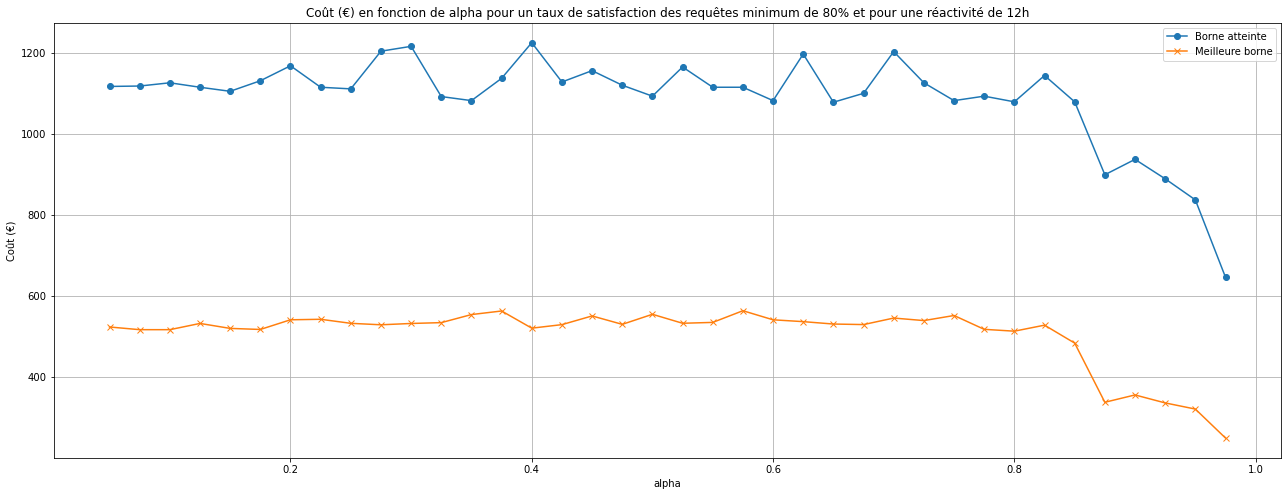

In [12]:
# Affichage des résultats de la cellule précédente
x_values = [point[5] for point in res]
y_values = [point[2] for point in res]
z_values = [point[3] for point in res]

plt.figure(figsize=(22,8))
plt.plot(x_values, y_values, marker='o', label='Borne atteinte')
plt.plot(x_values, z_values, marker='x', label='Meilleure borne')

plt.title('Coût (€) en fonction de alpha pour un taux de satisfaction des requêtes minimum de 80% et pour une réactivité de 12h')
plt.xlabel('alpha')
plt.ylabel('Coût (€)')
plt.legend()
plt.grid()
plt.show()

In [15]:
it = -1 # Analyse du dernier point
print(f"satisfaction score: {res[it][0]*100}%")
print(f"Nb access: {res[it][1]}")
print(f"Cost: {round(res[it][2], 0)}€")
print(f"Best bound: {round(res[it][3], 0)}€")
print(f"alpha: {res[it][5]}")

satisfaction score: 80.0%
Nb access: 2.0
Cost: 646.0€
Best bound: 249.0€
alpha: 0.9750000000000003
